In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [219]:
# load the data in training_dictionary.txt
with open("training_dictionary.txt", "r") as file:
    words = file.read().splitlines()

In [220]:
# Filter down to words less than 3 characters
max_length = 4
words = [word for word in words if len(word) == max_length]

In [221]:
print(len(words))
words[:10]

4798


['roit',
 'pari',
 'zips',
 'lena',
 'meed',
 'tuza',
 'ibid',
 'erne',
 'hupa',
 'acme']

In [222]:
len("".join(words))

19192

In [223]:
longest_word = max(words, key=len)
print(longest_word, len(longest_word))

roit 4


In [224]:
vocab = set("".join(words))
vocab = ["_"] + sorted(list(vocab))
vocab_size = len(vocab)
print(vocab_size)
stoi = {char: i for i, char in enumerate(vocab)}
itos = {i: char for char, i in stoi.items()}
print(stoi)
print(itos)

27
{'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '_', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [229]:
# create a dataset where each character is masked with an underscore
block_size = 4
dataset = []
# Truncate word to block_size or fill them with '.' if it's too short. Use '_' for the single masked character. There must only be one '_' per word.
truncated_words = []
for word in words:
    # Pad shorter words with '.' to match block_size
    # if len(word) < block_size:
    #     word = word + "." * (block_size - len(word))

    # Use sliding window to generate subwords
    for i in range(len(word) - block_size + 1):
        subword = word[i : i + block_size]
        truncated_words.append(subword)

print(len(truncated_words))
truncated_words[:10]

4798


['roit',
 'pari',
 'zips',
 'lena',
 'meed',
 'tuza',
 'ibid',
 'erne',
 'hupa',
 'acme']

In [235]:
def masked_words(word):
    if not word:
        return []

    result = []

    # Get unique characters in the word
    unique_chars = list(set(word))

    # Generate all possible combinations of which characters to mask
    # For n unique characters, we have 2^n possibilities
    for i in range(1, 2 ** len(unique_chars)):  # Start from 1 to exclude no masks
        chars_to_mask = set()

        # Determine which characters to mask based on bit pattern
        for j in range(len(unique_chars)):
            if i & (1 << j):
                chars_to_mask.add(unique_chars[j])

        # Create the masked string
        masked = ""
        for char in word:
            if char in chars_to_mask:
                masked += "_"
            else:
                masked += char

        # Create a tuple for each masked character type
        for char in chars_to_mask:
            result.append((masked, char))

    return result


print(masked_words("app"))
print(masked_words("xyz"))

[('_pp', 'a'), ('a__', 'p'), ('___', 'a'), ('___', 'p')]
[('xy_', 'z'), ('x_z', 'y'), ('x__', 'z'), ('x__', 'y'), ('_yz', 'x'), ('_y_', 'z'), ('_y_', 'x'), ('__z', 'y'), ('__z', 'x'), ('___', 'z'), ('___', 'y'), ('___', 'x')]


In [236]:
dataset = []
for word in truncated_words:
    dataset.extend(masked_words(word))

# print the first 10 elements of the dataset
print(len(dataset))
print(dataset[:10])

130720
[('r_it', 'o'), ('roi_', 't'), ('r_i_', 'o'), ('r_i_', 't'), ('_oit', 'r'), ('__it', 'o'), ('__it', 'r'), ('_oi_', 't'), ('_oi_', 'r'), ('__i_', 'o')]


In [237]:
# convert the words to a list of ints
integerized_dataset = []
for word, label in dataset:
    integerized_dataset.append(([stoi[char] for char in word], stoi[label]))

print(integerized_dataset[0])

([18, 0, 9, 20], 15)


In [238]:
# create a pytorch dataset of word and label pairs
from torch.utils.data import Dataset
import random


class HangmanDataset(Dataset):
    def __init__(self, words):
        self.features = torch.tensor([x[0] for x in words])
        self.labels = torch.tensor([x[1] for x in words])

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


split_idx = int(len(integerized_dataset) * 1)
shuffled_integerized_dataset = list(integerized_dataset)
random.shuffle(shuffled_integerized_dataset)
train_split = shuffled_integerized_dataset[:split_idx]
val_split = shuffled_integerized_dataset[split_idx:]

train_dataset = HangmanDataset(train_split)
val_dataset = HangmanDataset(val_split)

print(len(train_dataset))
print(train_dataset[[0, 1, 2]])

print(len(val_dataset))

130720
(tensor([[ 0,  0,  3,  0],
        [20,  0,  0,  5],
        [ 8,  5,  0, 16]]), tensor([21,  9,  1]))
0


Epoch 1/3


Loss: 2.8335: 100%|██████████| 256/256 [00:07<00:00, 34.39it/s]


Epoch 2/3


Loss: 2.7601: 100%|██████████| 256/256 [00:05<00:00, 47.04it/s]


Epoch 3/3


Loss: 2.7268: 100%|██████████| 256/256 [00:05<00:00, 47.36it/s]


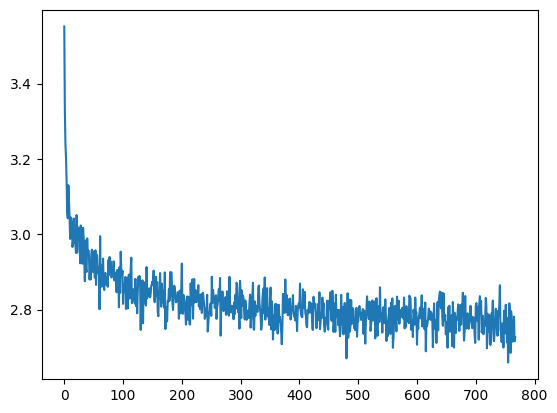

In [241]:
# Create a transformer model for the hangman game

import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm

d_model = 256
nhead = 4
num_layers = 2

device = "mps" if torch.backends.mps.is_available() else "cpu"


class HangmanTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dropout=0):
        super(HangmanTransformer, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dropout = dropout

        # Create positional encoding matrix
        self.embedding = nn.Embedding(vocab_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.position_embedding_table = nn.Embedding(block_size, d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.ln_f = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src):
        src = self.embedding(src)
        pos_emb = self.position_embedding_table(
            torch.arange(block_size).to(device)
        )  # (T,C)
        src = src + pos_emb
        output = self.transformer_encoder(src)
        output = self.ln_f(output)
        output = torch.mean(output, dim=1)
        logits = self.fc(output)
        return logits


# create a transformer model
model = HangmanTransformer(vocab_size, d_model, nhead, num_layers)

model.to(device)
# create a loss function
criterion = nn.CrossEntropyLoss()

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model
batch_size = 512
num_epochs = 3

lossi = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        idx = torch.randint(0, len(train_dataset), (batch_size,))
        features, labels = train_dataset[idx]
        features = features.to(device)
        labels = labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(features)

        labels = torch.nn.functional.one_hot(labels, num_classes=vocab_size)

        # Calculate loss
        loss = criterion(logits, labels.float())

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")
        lossi.append(loss.item())

plt.plot(lossi)
plt.show()

In [243]:
model.eval()
with torch.no_grad():
    losses = []
    for i in (pbar := tqdm(range(0, len(train_dataset), batch_size))):
        features, labels = train_dataset[i : i + batch_size]
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        loss = criterion(logits, labels)
        losses.append(loss.item())
    print(np.mean(losses))

100%|██████████| 256/256 [00:01<00:00, 174.86it/s]

2.7632444072514772


In [248]:
# inference:


def predict(model, word, max_guesses=6):
    # print("word", word)
    guesses = []
    model.eval()
    with torch.no_grad():
        while True:
            # print(guesses)
            masked_word = "".join(
                ["_" if guess not in guesses else guess for guess in word]
            )
            # print("masked_word", masked_word, guesses)
            if masked_word == word:
                break
            if len(guesses) >= max_guesses:
                break

            features = torch.tensor([[stoi[c] for c in masked_word]]).to(device)
            # print("features", features)
            logits = model.forward(features)
            probs = torch.softmax(logits, dim=1)
            # print("probs", probs)
            indices = torch.topk(probs, k=vocab_size - 1, dim=1).indices
            # print("indices", indices)
            letter_guesses = [itos[i] for i in indices[0].tolist()]
            # print("letter_guesses", letter_guesses)
            for letter_guess in letter_guesses:
                if letter_guess not in guesses and letter_guess != "_":
                    guesses.append(letter_guess)
                    if letter_guess in word or len(guesses) == max_guesses:
                        break
    return masked_word, guesses


wins = 0
total = 0
for word in (pbar := tqdm(words)):
    masked_word, guesses = predict(model, word)
    if masked_word == word:
        wins += 1
    total += 1
    pbar.set_description(f"Win rate: {wins / total * 100:.2f}%")

Win rate: 5.36%: 100%|██████████| 4798/4798 [00:59<00:00, 80.75it/s]
